ETL

Para comenzar el ETL, se debe realizar una importación de las pricipales librerias que se usarán en este
proyecto:

In [86]:
import pandas as pd
import numpy as np
import ast # con estaa libreria se evaluar expresiones literales de Python
import gzip # manejo de archivos comprimidos 
import json # Módulo para trabajar con JSON
import matplotlib.pyplot as plt
import seaborn as sns
import nltk #biblioteca nltk (Natural Language Toolkit)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re # Módulo para trabajar con expresiones regulares

Seguidamente, se carga el primer archivo de los datasets suministrados (steam_games.json.gz) en la variable stg:

In [87]:
stg = pd.read_json('../datasets/steam_games.json.gz',compression='gzip',lines=True)

Luego se visualiza como esta conformado el archivo de datos:

In [88]:
stg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 11.9+ MB


Se debe eliminar las filas que sean nulas en todos sus campos para disminuir el peso del archivo:

In [89]:
stg.dropna(how='all',inplace=True)

In [90]:
stg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32135 entries, 88310 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 3.4+ MB


In [91]:
print(stg.head())

              publisher                                             genres  \
88310         Kotoshiro      [Action, Casual, Indie, Simulation, Strategy]   
88311  Making Fun, Inc.               [Free to Play, Indie, RPG, Strategy]   
88312      Poolians.com  [Casual, Free to Play, Indie, Simulation, Sports]   
88313              彼岸领域                        [Action, Adventure, Casual]   
88314              None                                               None   

                      app_name                    title  \
88310      Lost Summoner Kitty      Lost Summoner Kitty   
88311                Ironbound                Ironbound   
88312  Real Pool 3D - Poolians  Real Pool 3D - Poolians   
88313                  弹炸人2222                  弹炸人2222   
88314            Log Challenge                     None   

                                                     url release_date  \
88310  http://store.steampowered.com/app/761140/Lost_...   2018-01-04   
88311  http://store.steampower

se debe eliminar registros donde el ID de este dataset sea duplicado y/o nulo ya que no aporta para la información final:

In [92]:
stg = stg.dropna(subset=['id'])

In [93]:
stg = stg.drop_duplicates(subset=['id'])

In [94]:
stg['id'] = stg['id'].astype('int') # Paso el id a entero
stg.isnull().sum() # Cuanto la cantidad de nulos

publisher       8051
genres          3282
app_name           1
title           2049
url                0
release_date    2066
tags             162
reviews_url        0
specs            669
price           1377
early_access       0
id                 0
developer       3298
dtype: int64

In [17]:
stg.sample(10)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88457,Telltale Games,[Adventure],Bone: The Great Cow Race,Bone: The Great Cow Race,http://store.steampowered.com/app/8320/Bone_Th...,2006-04-12,"[Adventure, Point & Click]",http://steamcommunity.com/app/8320/reviews/?br...,[Single-player],9.99,0.0,8320,Telltale Games
105517,Avant Games,"[Action, Adventure, Free to Play, Indie, RPG, ...",Dragon Souls,Dragon Souls,http://store.steampowered.com/app/510370/Drago...,Early Access Starting Soon!,"[Free to Play, Action, Adventure, Dragons, Str...",http://steamcommunity.com/app/510370/reviews/?...,"[Online Multi-Player, Steam Achievements, In-A...",None,0.0,510370,Avant Games
109537,None,[Action],DEAD OR ALIVE 5 Last Round: Core Fighters Char...,DEAD OR ALIVE 5 Last Round: Core Fighters Char...,http://store.steampowered.com/app/531170/DEAD_...,2016-10-03,[Action],http://steamcommunity.com/app/531170/reviews/?...,"[Single-player, Multi-player, Downloadable Con...",3.99,0.0,531170,"Team NINJA,KOEI TECMO GAMES CO., LTD."
114810,Diabolical Mind,"[Action, Adventure, Indie, RPG]",Riddled Corpses,Riddled Corpses,http://store.steampowered.com/app/369890/Riddl...,2015-06-02,"[Action, Indie, RPG, Adventure, Shoot 'Em Up, ...",http://steamcommunity.com/app/369890/reviews/?...,"[Single-player, Co-op, Steam Achievements, Ful...",7.99,0.0,369890,Daniel Fernandez Chavez
104530,Craftven,"[Action, Casual, Indie, Sports, Strategy]",Lupinball,Lupinball,http://store.steampowered.com/app/429360/Lupin...,2017-08-17,"[Action, Indie, Sports, Casual, Strategy, Pixe...",http://steamcommunity.com/app/429360/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",9.99,0.0,429360,Craftven
95805,None,None,Out of Print,Out of Print,http://store.steampowered.com/app/537870/Out_o...,2016-04-29,"[Historical, Documentary]",http://steamcommunity.com/app/537870/reviews/?...,[Captions available],4.99,0.0,537870,None
118728,Ubisoft,"[Casual, Simulation]",Rocksmith - Eric Johnson - Cliffs of Dover,Rocksmith - Eric Johnson - Cliffs of Dover,http://store.steampowered.com/app/222073/Rocks...,2013-01-15,"[Casual, Simulation]",http://steamcommunity.com/app/222073/reviews/?...,"[Single-player, Shared/Split Screen, Downloada...",2.99,0.0,222073,Ubisoft - San Francisco
95834,Flying Helmet Games,"[Action, Adventure, Indie, RPG]",Eon Altar: Episode 2 - Whispers in the Catacombs,Eon Altar: Episode 2 - Whispers in the Catacombs,http://store.steampowered.com/app/477890/Eon_A...,2016-10-06,"[RPG, Indie, Action, Adventure, Co-op Campaign...",http://steamcommunity.com/app/477890/reviews/?...,"[Single-player, Multi-player, Local Multi-Play...",6.99,0.0,477890,Flying Helmet Games
118908,1C Company,"[RPG, Strategy]",King's Bounty: Warriors of the North,King's Bounty: Warriors of the North,http://store.steampowered.com/app/203350/Kings...,2012-10-25,"[RPG, Strategy, Turn-Based Strategy, Tactical,...",http://steamcommunity.com/app/203350/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",9.99,0.0,203350,1C-SoftClub
88436,Ubisoft,[Action],Tom Clancy's Splinter Cell®,Tom Clancy's Splinter Cell®,http://store.steampowered.com/app/13560/Tom_Cl...,2003-02-18,"[Stealth, Action, Third Person, Singleplayer, ...",http://steamcommunity.com/app/13560/reviews/?b...,[Single-player],9.99,0.0,13560,Ubisoft


Ahora se eliminan las columnas que no se requieren para el análisis de las funciones:

In [95]:
stg.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88310,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,0.0,761140,Kotoshiro
88311,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,0.0,643980,Secret Level SRL
88312,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,0.0,670290,Poolians.com
88313,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,0.0,767400,彼岸领域
88314,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"[Action, Indie, Casual, Sports]",http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,0.0,773570,None


In [96]:
stg3=stg

In [97]:
stg1= stg.drop(columns=['title','url','reviews_url','early_access','specs','tags', 'developer'])

In [98]:
stg1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32132 entries, 88310 to 120444
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24081 non-null  object
 1   genres        28850 non-null  object
 2   app_name      32131 non-null  object
 3   release_date  30066 non-null  object
 4   price         30755 non-null  object
 5   id            32132 non-null  int32 
dtypes: int32(1), object(5)
memory usage: 1.6+ MB


In [99]:
stg1.head()

,publisher,genres,app_name,release_date,price,id
88310,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,4.99,761140
88311,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,Free To Play,643980
88312,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,Free to Play,670290
88313,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,0.99,767400
88314,None,None,Log Challenge,None,2.99,773570


Es necesario eliminar los registros nulos para las columnas de generos y año de lanzamiento:

In [100]:
stg1 = stg1.dropna(subset=['genres'])
stg1 = stg1.dropna(subset=['release_date'])

In [101]:
stg1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28832 entries, 88310 to 120443
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     23936 non-null  object
 1   genres        28832 non-null  object
 2   app_name      28831 non-null  object
 3   release_date  28832 non-null  object
 4   price         27616 non-null  object
 5   id            28832 non-null  int32 
dtypes: int32(1), object(5)
memory usage: 1.4+ MB


In [102]:
stg1['release_date'].value_counts()

release_date
2012-10-16    100
2017-08-31     92
2017-09-26     88
2017-07-25     78
2017-12-19     75
             ... 
2021-12-31      1
2014-05-04      1
2018-12-20      1
1999-03-22      1
2018-10-01      1
Name: count, Length: 3392, dtype: int64

Se debe normalizar y estandarizar el campo de fecha ya que contiene muchas formas de escritura:

In [103]:
def normalizar(fecha: str):
    try:
        # convierte la fecha  a entero
        return int(fecha)
    except ValueError:
        try:
            # divide la fecha usando un espacio en blanco como delimitador y convierte la segunda parte a entero
            return int(fecha.split(" ")[1])
        except (IndexError, ValueError):
            try:
                # divide la fecha usando "." como delimitador y convierte la tercera parte a entero
                return int(fecha.split(".")[2])
            except (IndexError, ValueError):
                try:
                    # divide la fecha usando un espacio en blanco como delimitador y convierte la quinta parte a entero
                    return int(fecha.split(" ")[4])
                except (IndexError, ValueError):
                    # Si no se puede convertir, devuelve None
                    return None

In [105]:
# Función para verificar el formato 'YYYY-MM-DD'
def dates(date_str):
    regex = r'^\d{4}-\d{2}-\d{2}$'
    return re.match(regex, date_str) is not None

# Crear una máscara booleana para las fechas que no tienen el formato 'YYYY-MM-DD'
mascara = ~stg1['release_date'].astype(str).apply(dates)

# Filtrar las filas con fechas que no tienen el formato 'YYYY-MM-DD'
no_dates = stg1[mascara]

# Mostrar las filas con fechas que no tienen el formato 'YYYY-MM-DD'
print(stg1[mascara]['release_date'])

88320           Soon..
88353             2017
88354        Beta测试已开启
88560         Jun 2009
88816         Oct 2010
              ...     
120392      15.01.2018
120393        Q1, 2018
120397     Coming Soon
120407            2016
120433    January 2018
Name: release_date, Length: 285, dtype: object


In [106]:
stg1.loc[mascara, 'year'] = stg1.loc[mascara, 'release_date'].apply(normalizar)

# Convertir las fechas válidas a datetime y extraer el año
mascara = ~mascara

stg1.loc[mascara, 'year'] = pd.to_datetime(stg1.loc[mascara, 'release_date'], errors='coerce').dt.year


In [107]:
stg1['year'] = stg1['year'].astype(float)

In [108]:
print(stg1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28832 entries, 88310 to 120443
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     23936 non-null  object 
 1   genres        28832 non-null  object 
 2   app_name      28831 non-null  object 
 3   release_date  28832 non-null  object 
 4   price         27616 non-null  object 
 5   id            28832 non-null  int32  
 6   year          28714 non-null  float64
dtypes: float64(1), int32(1), object(5)
memory usage: 1.6+ MB
None


Se elimina ahora la columna release_date ya que no se requiere más.

In [109]:
stg1.drop(columns=['release_date'],inplace=True)

In [110]:
stg1.head()

,publisher,genres,app_name,price,id,year
88310,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,4.99,761140,2018.0
88311,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Free To Play,643980,2018.0
88312,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Free to Play,670290,2017.0
88313,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,0.99,767400,2017.0
88315,Trickjump Games Ltd,"[Action, Adventure, Simulation]",Battle Royale Trainer,3.99,772540,2018.0


In [111]:
stg1['year'].isnull().sum()

118

In [112]:
stg1['year'].dropna(inplace=True)

In [113]:
stg1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28832 entries, 88310 to 120443
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   publisher  23936 non-null  object 
 1   genres     28832 non-null  object 
 2   app_name   28831 non-null  object 
 3   price      27616 non-null  object 
 4   id         28832 non-null  int32  
 5   year       28714 non-null  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 1.4+ MB


In [114]:
stg1 = stg1.explode('genres').reset_index()  

In [115]:
stg1.head()

,index,publisher,genres,app_name,price,id,year
0,88310,Kotoshiro,Action,Lost Summoner Kitty,4.99,761140,2018.0
1,88310,Kotoshiro,Casual,Lost Summoner Kitty,4.99,761140,2018.0
2,88310,Kotoshiro,Indie,Lost Summoner Kitty,4.99,761140,2018.0
3,88310,Kotoshiro,Simulation,Lost Summoner Kitty,4.99,761140,2018.0
4,88310,Kotoshiro,Strategy,Lost Summoner Kitty,4.99,761140,2018.0


se elimina la columna index ya que no se necesita

In [116]:
stg1.drop(columns=['index'],inplace=True)

se realiza una muestra de 2000 items para almacena en dataframe stg2, por la razón de trabajar de forma liviana 
en API Render.

In [117]:
stg2 = stg1.sample(2000)

In [118]:
stg2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 69023 to 35190
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   publisher  1676 non-null   object 
 1   genres     2000 non-null   object 
 2   app_name   2000 non-null   object 
 3   price      1900 non-null   object 
 4   id         2000 non-null   int32  
 5   year       1989 non-null   float64
dtypes: float64(1), int32(1), object(4)
memory usage: 101.6+ KB


se crea el archivo steam games en formato csv y se guarda en la carpeta datasets

In [74]:
stg2.to_csv('../datasets/steam_games.csv',index=False)

el dataframe stg1 contiene los datos preprocesados antes de la muestra, para poder desarrollar análisis 
posteriores en EDA. Así, se crea el archivo steam games 2

In [119]:
stg1.to_csv('../datasets/steam_games2.csv',index=False)

ARCHIVO USER ITEMS

este tipo de archivo comprimido json se debe tratar con una función especial como la siguiente:

In [40]:
def read_json(name):
    data=[]

    with gzip.open(name, 'rb') as file:
        for line in file:
            deco = line.decode('utf-8')
            data.append(ast.literal_eval(deco.strip()))
        return data


In [41]:
arch = "../datasets/users_items.json.gz"
items = read_json(arch)

In [42]:
df = pd.DataFrame(items)                                                 
 

In [48]:
df.describe()

,items_count
count,88310.000000
mean,58.353629
std,122.312095
min,0.000000
25%,3.000000
50%,26.000000
75%,73.000000
max,7762.000000


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [50]:
df.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


se utiliza la funcióon explode para expandir la columna items, la cual contiene listas en filas separadas

In [43]:
df = df.explode('items').reset_index()   

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 6 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   index        int64 
 1   user_id      object
 2   items_count  int64 
 3   steam_id     object
 4   user_url     object
 5   items        object
dtypes: int64(2), object(4)
memory usage: 236.7+ MB


In [44]:
df = df.drop(columns="index") 

se concatena el datafframe para ña columna items

In [45]:
df = pd.concat([df, pd.json_normalize(df['items'])], axis=1)  

In [55]:
df.describe()

,items_count,playtime_forever,playtime_2weeks
count,5.170015e+06,5.153209e+06,5.153209e+06
mean,3.136999e+02,9.914951e+02,9.104707e+00
std,6.924635e+02,5.418204e+03,1.403926e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.100000e+01,0.000000e+00,0.000000e+00
50%,1.370000e+02,3.400000e+01,0.000000e+00
75%,2.750000e+02,3.550000e+02,0.000000e+00
max,7.762000e+03,6.427730e+05,1.996700e+04


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   items_count       int64  
 2   steam_id          object 
 3   user_url          object 
 4   items             object 
 5   item_id           object 
 6   item_name         object 
 7   playtime_forever  float64
 8   playtime_2weeks   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 355.0+ MB


In [57]:
df.isnull().sum()

user_id                 0
items_count             0
steam_id                0
user_url                0
items               16806
item_id             16806
item_name           16806
playtime_forever    16806
playtime_2weeks     16806
dtype: int64

In [46]:
df[df['item_id'].isna()]

,user_id,items_count,steam_id,user_url,items,item_id,item_name,playtime_forever,playtime_2weeks
3733,Wackky,0,76561198039117046,http://steamcommunity.com/id/Wackky,NaN,NaN,NaN,NaN,NaN
3849,76561198079601835,0,76561198079601835,http://steamcommunity.com/profiles/76561198079...,NaN,NaN,NaN,NaN,NaN
6019,hellom8o,0,76561198117222320,http://steamcommunity.com/id/hellom8o,NaN,NaN,NaN,NaN,NaN
6523,starkillershadow553,0,76561198059648579,http://steamcommunity.com/id/starkillershadow553,NaN,NaN,NaN,NaN,NaN
7237,darkenkane,0,76561198058876001,http://steamcommunity.com/id/darkenkane,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5169470,76561198316380182,0,76561198316380182,http://steamcommunity.com/profiles/76561198316...,NaN,NaN,NaN,NaN,NaN
5169471,76561198316970597,0,76561198316970597,http://steamcommunity.com/profiles/76561198316...,NaN,NaN,NaN,NaN,NaN
5169472,76561198318100691,0,76561198318100691,http://steamcommunity.com/profiles/76561198318...,NaN,NaN,NaN,NaN,NaN
5170006,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,NaN,NaN,NaN,NaN,NaN


In [47]:
df.dropna(inplace=True)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5153209 entries, 0 to 5170013
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   items_count       int64  
 2   steam_id          object 
 3   user_url          object 
 4   items             object 
 5   item_id           object 
 6   item_name         object 
 7   playtime_forever  float64
 8   playtime_2weeks   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 393.2+ MB


In [60]:
df['playtime_forever'].dropna(inplace=True)
df['item_name'].dropna(inplace=True)
df['user_id'].dropna(inplace=True)


In [26]:
df.describe()

,items_count,playtime_forever,playtime_2weeks
count,5.153209e+06,5.153209e+06,5.153209e+06
mean,3.147229e+02,9.914951e+02,9.104707e+00
std,6.933596e+02,5.418204e+03,1.403926e+02
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.200000e+01,0.000000e+00,0.000000e+00
50%,1.380000e+02,3.400000e+01,0.000000e+00
75%,2.760000e+02,3.550000e+02,0.000000e+00
max,7.762000e+03,6.427730e+05,1.996700e+04


In [48]:
df.drop(columns=['user_url', 'playtime_2weeks', 'items'], inplace=True)

In [62]:
df.head()

,user_id,items_count,steam_id,item_id,item_name,playtime_forever
0,76561197970982479,277,76561197970982479,10,Counter-Strike,6.0
1,76561197970982479,277,76561197970982479,20,Team Fortress Classic,0.0
2,76561197970982479,277,76561197970982479,30,Day of Defeat,7.0
3,76561197970982479,277,76561197970982479,40,Deathmatch Classic,0.0
4,76561197970982479,277,76561197970982479,50,Half-Life: Opposing Force,0.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5153209 entries, 0 to 5170013
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   items_count       int64  
 2   steam_id          object 
 3   item_id           object 
 4   item_name         object 
 5   playtime_forever  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 275.2+ MB


In [70]:
df1 = df.sample(2000)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 2559536 to 4381565
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           2000 non-null   object 
 1   items_count       2000 non-null   int64  
 2   steam_id          2000 non-null   object 
 3   item_id           2000 non-null   object 
 4   item_name         2000 non-null   object 
 5   playtime_forever  2000 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 109.4+ KB


In [71]:

df1.to_csv('../datasets/user_item.csv',index=False)

In [49]:
df.to_csv('../datasets/user_item2.csv',index=False)

USER REVIEWS

se carga el archivo user reviews

se realiza tratamiento para desanidar la columna reviews

In [3]:
user_reviews = "../datasets/user_reviews.json.gz"
filas=[]
with gzip.open(user_reviews, 'rt', encoding='utf-8') as archivo:
    for line in archivo.readlines():
        filas.append(ast.literal_eval(line))

rev = pd.DataFrame(filas)

In [4]:
rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


In [5]:
rev.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


Se debe desanidar el campo reviews ya que contiene diccionario anidado con más datos de reconendaciones de usuarios. se usa las funciones explode y concatenate

In [6]:
rev2 = rev.explode('reviews') # se genera un diccionario por cada diccionario en la lista y se concantena

rev2 = pd.concat([rev2.drop(['reviews'],axis=1),rev2['reviews'].apply(pd.Series)],axis=1)  

se elimina columnas inncesarias para el análisis

In [7]:
rev2.drop(columns=['user_url','funny','helpful','last_edited',0],inplace=True)

In [8]:
rev2.head()

,user_id,posted,item_id,recommend,review
0,76561197970982479,"Posted November 5, 2011.",1250,True,Simple yet with great replayability. In my opi...
0,76561197970982479,"Posted July 15, 2011.",22200,True,It's unique and worth a playthrough.
0,76561197970982479,"Posted April 21, 2011.",43110,True,Great atmosphere. The gunplay can be a bit chu...
1,js41637,"Posted June 24, 2014.",251610,True,I know what you think when you see this title ...
1,js41637,"Posted September 8, 2013.",227300,True,For a simple (it's actually not all that simpl...


Las funciones están relacionadas con la biblioteca NLTK (Natural Language Toolkit), específicamente con el análisis de sentimientos utilizando el paquete VADER (Valence Aware Dictionary and sEntiment Reasoner)

se define la funcion sentiment

In [10]:
nltk.download('vader_lexicon')
model = SentimentIntensityAnalyzer()


def sentiment(review):
    # Obtener el puntaje de sentimiento usando SentimentIntensityAnalyzer
    clasif = model.polarity_scores(review)
    
    # Clasifico el sentimiento
    
    if review and not pd.isnull(review):
        if clasif['compound'] >= 0.5:
            return 2  # Sentimiento positivo
        elif clasif['compound'] <= -0.5:
            return 0  # Sentimiento negativo
        else:
            return 1  # Sentimiento neutral
    else:
        return 1

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jupai\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
rev2['review'].fillna('',inplace=True) # Remplazo los nulos con un string vacio


C:\Users\jupai\AppData\Local\Temp\ipykernel_12524\2213859600.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rev2['review'].fillna('',inplace=True) # Remplazo los nulos con un string vacio


In [12]:
rev2['sentiment_analysis']  = rev2['review'].apply(sentiment)
rev2.drop(columns='review',inplace=True) # Aplica la funcion que determina el sentimiento

<Axes: xlabel='sentiment_analysis', ylabel='Count'>

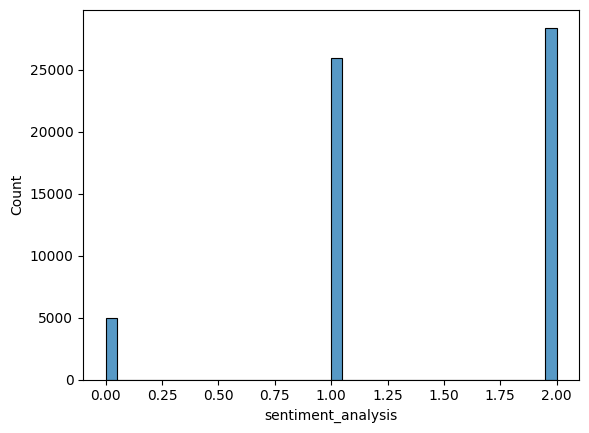

In [13]:
sns.histplot(data=rev2,x='sentiment_analysis')

In [14]:
rev2.isnull().sum()

user_id                0
posted                28
item_id               28
recommend             28
sentiment_analysis     0
dtype: int64

In [15]:
rev2.dropna(inplace=True)

In [16]:
rev2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59305 entries, 0 to 25798
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             59305 non-null  object
 1   posted              59305 non-null  object
 2   item_id             59305 non-null  object
 3   recommend           59305 non-null  object
 4   sentiment_analysis  59305 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


In [51]:
rev3=rev2.sample(2000)

In [53]:
rev2.to_csv('../datasets/user_reviews2.csv',index=False)

In [52]:
rev3.to_csv('../datasets/user_reviews.csv',index=False)